In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_hyperparams(base_dir="../saved_models/cgan_hyperparam_runs"):
    run_metrics = []
    param_values = {}
    
    for run_name in os.listdir(base_dir):
        run_path = os.path.join(base_dir, run_name)
        val_loss_file = os.path.join(run_path, "val_losses.csv")
        qpo_file = os.path.join(run_path, "qpo_scores.csv")
        
        if not os.path.isfile(val_loss_file):
            continue
        
        # Extract hyperparameters
        params = {}
        parts = run_name.split('_')
        parts = parts[2:] if len(parts) > 2 and parts[0] == "run" else parts
        
        for part in parts:
            if part.startswith('z') and part[1:].isdigit():
                params['z_dim'] = int(part[1:])
                param_values.setdefault('z_dim', set()).add(int(part[1:]))
            elif part.startswith('lr'):
                params['learning_rate'] = float(part[2:])
                param_values.setdefault('learning_rate', set()).add(float(part[2:]))
            elif part.startswith('bs'):
                params['batch_size'] = int(part[2:])
                param_values.setdefault('batch_size', set()).add(int(part[2:]))
        
        # Process loss data
        loss_df = pd.read_csv(val_loss_file)
        df_stable = loss_df[loss_df["epoch"] >= 10]
        
        if df_stable.empty or len(df_stable) < 10:
            continue
            
        # Loss metrics
        min_loss = df_stable["val_gen_loss"].min()
        final_loss = df_stable["val_gen_loss"].iloc[-1]
        avg_std = df_stable["val_gen_loss"].rolling(window=10).std().dropna().mean()
        max_jump = df_stable["val_gen_loss"].diff().abs().max()
        slope, _, _, _, _ = linregress(df_stable["epoch"], df_stable["val_gen_loss"])
        
        # Stability score
        stability_score = (1/(avg_std+1e-6)) + (1/(max_jump+1e-6)) - abs(slope) + (1/(final_loss+1e-6)) + (1/(min_loss+1e-6))
        
        # QPO metrics
        qpo_score = 0
        if os.path.isfile(qpo_file):
            qpo_df = pd.read_csv(qpo_file)
            qpo_col = [c for c in qpo_df.columns if "qpo" in c.lower() or "score" in c.lower()][0]
            qpo_score = qpo_df[qpo_col].max() + qpo_df[qpo_col].iloc[-1] + qpo_df[qpo_col].mean()
        
        # Overall score
        overall_score = stability_score * 0.5 + qpo_score * 0.5 if qpo_score > 0 else stability_score * 2
        
        # Store metrics
        run_metrics.append({
            "Run": run_name,
            **params,
            "Min_Loss": min_loss,
            "Final_Loss": final_loss,
            "Stability_Score": stability_score,
            "QPO_Score": qpo_score if qpo_score > 0 else np.nan,
            "Overall_Score": overall_score
        })
    
    # Create and sort metrics dataframe
    metrics_df = pd.DataFrame(run_metrics)
    metrics_df = metrics_df.sort_values("Overall_Score", ascending=False).reset_index(drop=True)
    
    return metrics_df

metrics_df = evaluate_hyperparams()

print("\n=== Top Runs by Overall Score ===")
display_cols = ["Run", "Overall_Score", "Stability_Score", "QPO_Score", "Min_Loss", "Final_Loss"]
print(metrics_df[display_cols].head(10))



=== Top Runs by Overall Score ===
                         Run  Overall_Score  Stability_Score    QPO_Score  \
0  run_8_z100_lr0.0005_bs128    1054.533542         6.155942  2102.911143   
1     run_1_z64_lr0.001_bs64     975.896972         2.630005  1949.163939   
2   run_4_z64_lr0.0005_bs128     646.234264         7.488089  1284.980439   
3    run_2_z64_lr0.001_bs128     517.931684         6.260251  1029.603117   
4    run_5_z100_lr0.001_bs64     513.558550         5.224053  1021.893047   
5   run_6_z100_lr0.001_bs128     321.493733         4.033985   638.953481   
6    run_3_z64_lr0.0005_bs64     103.675137         8.331819   199.018455   
7   run_7_z100_lr0.0005_bs64      72.282159         4.007267   140.557051   

   Min_Loss  Final_Loss  
0  0.632493    0.776440  
1  0.527455    4.064390  
2  0.562372    0.628006  
3  0.426153    1.221084  
4  0.632846    4.682684  
5  0.471478    7.152989  
6  0.292040    0.560721  
7  0.582734    3.716961  


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_hyperparam_results(metrics_df, top_n=8):
    """
    Creates a visualization of hyperparameter evaluation results
    
    Args:
        metrics_df: DataFrame with run metrics
        top_n: Number of top runs to display
    
    Returns:
        matplotlib.figure.Figure: The generated figure
    """
    # Only use top N runs
    top_runs = metrics_df.head(top_n)
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [1, 1]})
    
    # 1. Overall performance plot
    ax1 = axes[0]
    metrics_to_plot = ["Overall_Score", "Stability_Score", "QPO_Score"]
    
    # Create a grouped bar chart
    x = np.arange(len(top_runs))
    width = 0.25
    
    # Normalize the scores for better visualization
    norm_scores = top_runs[metrics_to_plot].copy()
    for col in metrics_to_plot:
        if col in norm_scores.columns:
            max_val = norm_scores[col].max()
            if max_val > 0:
                norm_scores[col] = norm_scores[col] / max_val * 100
    
    # Plot bars
    ax1.bar(x - width, norm_scores["Overall_Score"], width, label="Overall Score")
    ax1.bar(x, norm_scores["Stability_Score"], width, label="Stability Score")
    ax1.bar(x + width, norm_scores["QPO_Score"], width, label="QPO Score")
    
    # Customize plot
    ax1.set_ylabel("Normalized Score (%)")
    ax1.set_title("Performance Comparison of Top Runs")
    ax1.set_xticks(x)
    ax1.set_xticklabels([run.split('_', 1)[1] if run.startswith('run_') else run for run in top_runs["Run"]], 
                        rotation=45, ha="right")
    ax1.legend()
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 2. Loss metrics plot
    ax2 = axes[1]
    loss_metrics = ["Min_Loss", "Final_Loss"]
    
    # Create normalized version for better visualization
    x = np.arange(len(top_runs))
    width = 0.4
    
    min_losses = top_runs["Min_Loss"]
    final_losses = top_runs["Final_Loss"]
    
    # Plot bars
    min_bars = ax2.bar(x - width/2, min_losses, width, label="Min Validation Loss")
    final_bars = ax2.bar(x + width/2, final_losses, width, label="Final Validation Loss")
    
    # Add value labels on bars
    for i, (min_val, final_val) in enumerate(zip(min_losses, final_losses)):
        ax2.text(i - width/2, min_val + 0.05, f"{min_val:.2f}", ha='center', va='bottom', fontsize=8)
        ax2.text(i + width/2, final_val + 0.05, f"{final_val:.2f}", ha='center', va='bottom', fontsize=8)
    
    # Customize plot
    ax2.set_ylabel("Loss Value")
    ax2.set_title("Validation Loss Comparison")
    ax2.set_xticks(x)
    ax2.set_xticklabels([run.split('_', 1)[1] if run.startswith('run_') else run for run in top_runs["Run"]], 
                        rotation=45, ha="right")
    ax2.legend()
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    
    # Save figure
    plt.savefig("hyperparameter_evaluation.png", dpi=300, bbox_inches="tight")
    
    return fig


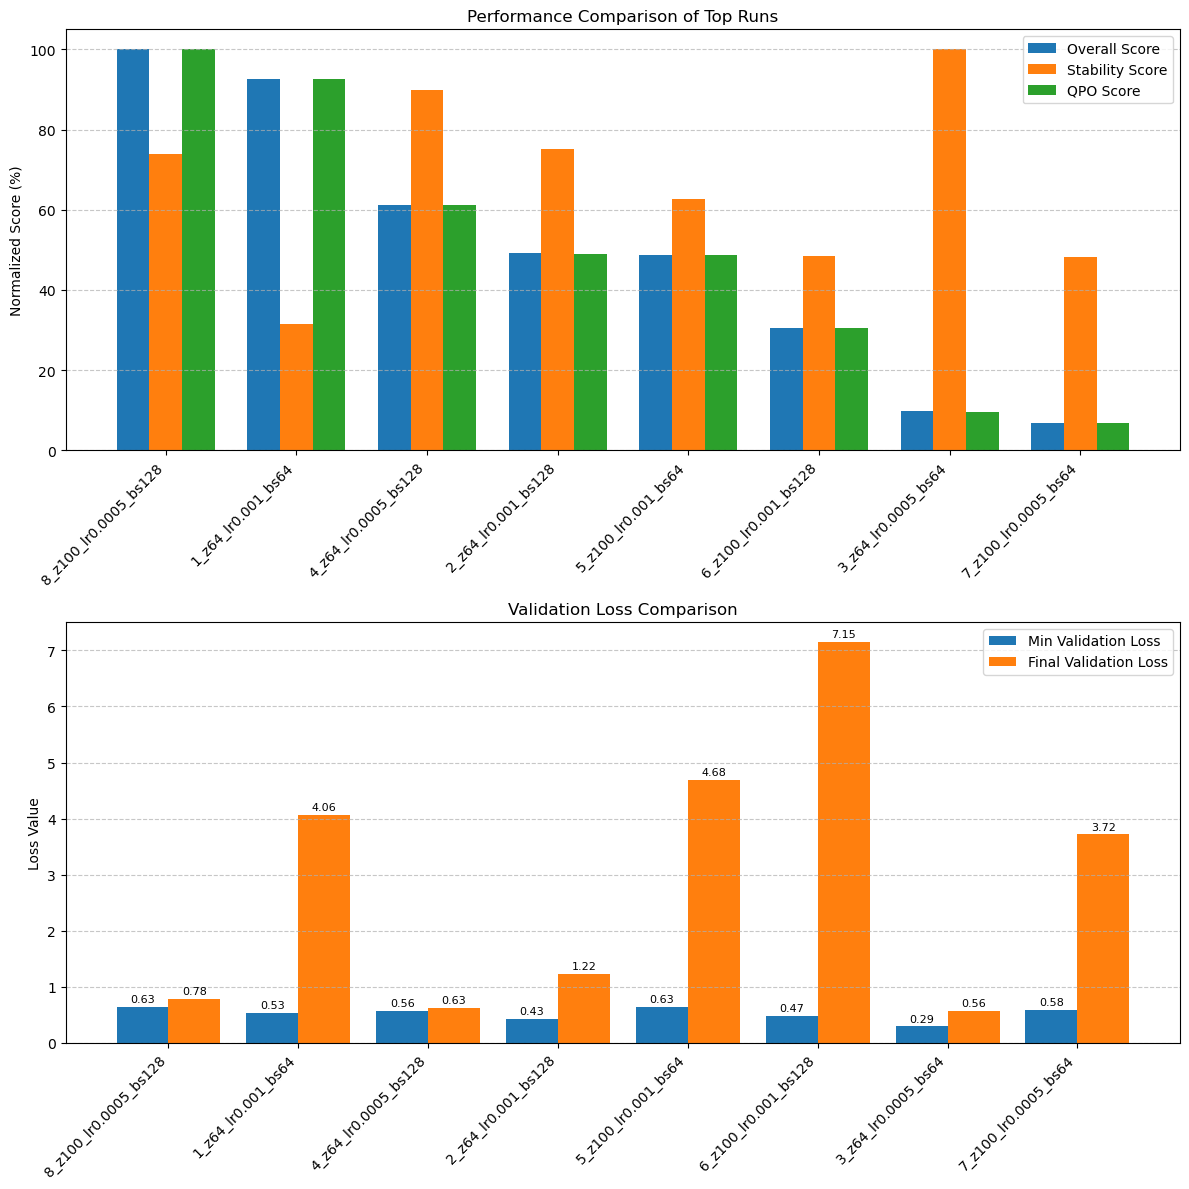

In [3]:
fig = plot_hyperparam_results(metrics_df)
plt.show()